In [1]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 18

### Prediction, Correlation, Regression

# Prediction

## Prediction Problems

* Predicting one characteristic based on another:
    - Given my height, how tall will my kid be as an adult?
    - Given my education level, what is my income?
    - Given my income, how much does my car cost?
    
* Two characteristics: one is known; one is unknown
* Have data for which we know both characteristics
* To predict, need an association

### Predict child height from height of parents

* Use mid-parent height as before.
* observation: Children of shorter parents tend to be shorter

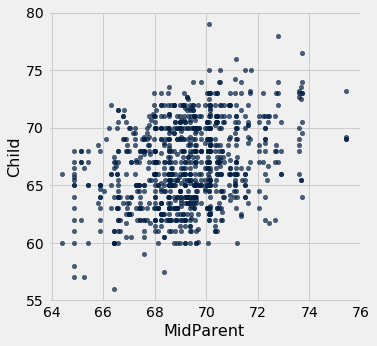

In [3]:
#:
galton = Table.read_table('galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )

heights.scatter(0)

### Predict child height from height of parents
* For a given child, predict their height by:
    - restricting ourselves to all midparents within $\pm 0.5$ inches of the child's midparent height;
    - averaging the height of all children of those midparents.

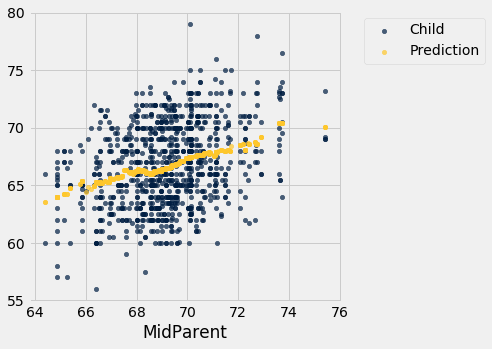

In [6]:
#:
def predict_child(parent):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of parent.
    """
    close_points = heights.where('MidParent', are.between(parent - 0.5, parent + 0.5))
    return close_points.column('Child').mean()

heights_and_predict = heights.with_column(
    'Prediction', heights.apply(predict_child, 'MidParent')
)

heights_and_predict.scatter(0)

## Graph of Averages
A visualization of x and y pairs
* Group each x value with other nearby x values
* Average the corresponding y values for each group
* For each x value, produce one predicted y value

## Relations between two variables
* Association
* Trend
    - Positive association
    - Negative association
* Pattern
    - Any discernible "shape"
    - Linear
    - Non-Linear

## Variable relationships: hybrid cars

In [7]:
#:
hybrid = Table.read_table('hybrid.csv')
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


### Acceleration and price
* Is there an association?
* What kind of association?

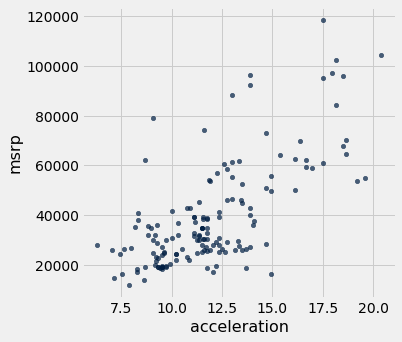

In [9]:
hybrid.scatter('acceleration', 'msrp')

### Discussion Question

This scatter plot shows that people are generally:

|Option|Answer|
|---|---|
|A.|Willing to pay more for cars that accelerate faster|
|B.|Willing to pay more for certain cars because they accelerate faster|
|C.|Not willing to pay more for cars that accelerate faster|
|D.|More than one of the above|

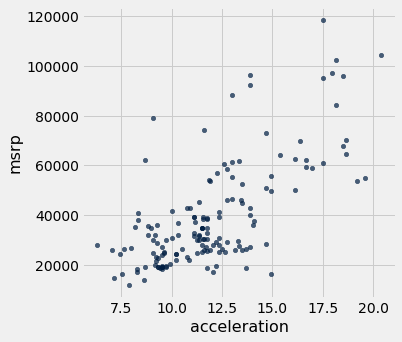

In [15]:
#:
hybrid.scatter('acceleration', 'msrp')

### Fuel economy and price

* Is there an association?
* What kind of association?

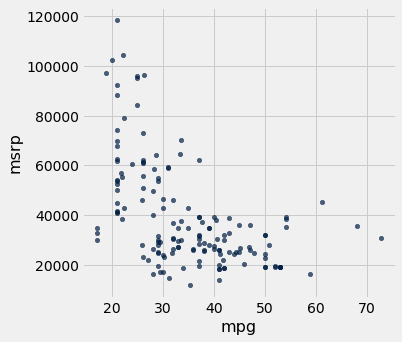

In [17]:
hybrid.scatter('mpg', 'msrp')

### Observations
* There is an association:
    - Are people more willing to pay less for certain cars because they want poor fuel economy?
* The association looks more curved than linear, like $~\frac{1}{x}$

### Understanding units 
* A linear change in units doesn't change the shape of the plot.
* The scale *does* change with the units.

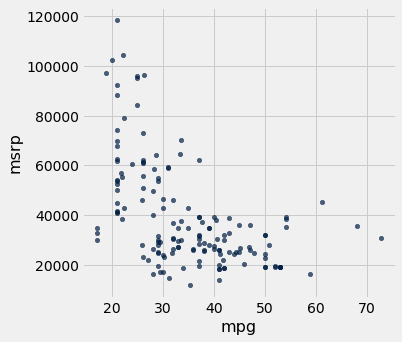

In [24]:
hybrid.scatter('mpg', 'msrp')

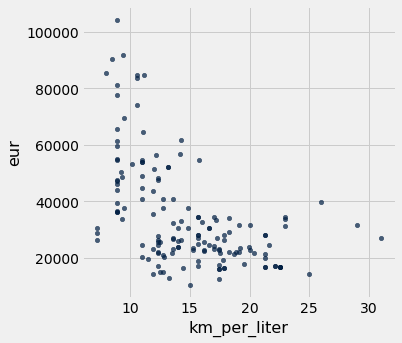

In [25]:
hybrid.with_columns(
        'km_per_liter', hybrid.column('mpg') * 0.425144,
        'eur', hybrid.column('msrp') * 0.88 
).scatter('km_per_liter', 'eur')

### Converting columns to standard units
* makes different scatterplots comparable
* allows x and y axis to be "similarly scaled"
    - both axes measure standard deviations from their means
* doesn't change shape of the scatterplot (conversion is linear)

In [26]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)

In [27]:
def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

### Standard units: hybrid cars
* For a given pair of variables:
    - which cars are average from both perspectives?
    - which cars are both well above/below average?

In [36]:
hybrid_su = standardize(hybrid.select('msrp', 'acceleration','mpg'))
hybrid_su

msrp (su),acceleration (su),mpg (su)
-0.69363,-1.53501,0.59091
-0.18568,-1.2825,1.76495
-0.584852,-1.36098,0.953911
-0.954663,-0.832081,1.66437
-0.631636,-1.67832,1.11941
-0.949966,-0.832081,1.66437
-0.945268,-0.767248,1.66437
-0.057827,-1.23814,0.517761
-0.945268,-0.832081,1.66437
-1.1825,-1.13919,0.567137


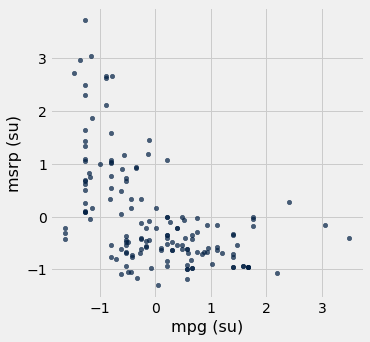

In [37]:
hybrid_su.scatter('mpg (su)', 'msrp (su)')

In [39]:
(
    hybrid_su
    .with_column('vehicle', hybrid.column('vehicle'))
    .where('mpg (su)', are.between(-0.2, 0.2))
    .where('msrp (su)', are.between(-0.2, 0.2))
)

msrp (su),acceleration (su),mpg (su),vehicle
-0.0847068,0.723914,-0.105833,Audi Q5
0.168841,-0.402135,0.0185203,Chevrolet Volt


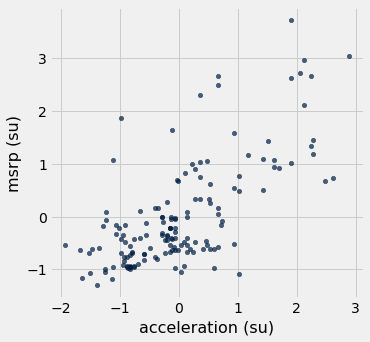

In [40]:
hybrid_su.scatter('acceleration (su)', 'msrp (su)')

In [42]:
(
    hybrid_su
    .with_column('vehicle', hybrid.column('vehicle'))
    .where('acceleration (su)', are.above(2))
    .where('msrp (su)', are.above(2))
)

msrp (su),acceleration (su),mpg (su),vehicle
2.71268,2.04788,-1.46091,ActiveHybrid X6
3.04346,2.88388,-1.16009,ActiveHybrid 7
2.96409,2.12295,-1.35302,ActiveHybrid 7i
2.10672,2.12295,-0.89584,ActiveHybrid 7L
2.66173,2.23896,-0.89584,Panamera S


### Observation on associations in standard units
* If two attributes are positively associated,
    - their high, positive values in standard units are typically seen together,
    - their low, negative values are seen together as well.
* If two attributes are negatively associated,
    - high, positive values of one are typically coupled with low, negative values of the other.
* If two attributes aren't associated, there shouldn't be pattern in their relative sizes.

## Definition: Correlation Coefficient

**Definition**: The correlation coefficient $r$ of two attributes $x$ and $y$ is the average value of the product of $x$ and $y$ when measured in standard units.

* If `x` and `y` are arrays (i.e. columns in a table): 
```
r = np.mean(x_su * y_su)
```
where `x_su` and `y_su` are `x` and `y` converted to standard units.


### Calculate the $r$ for `acceleration` and `msrp`

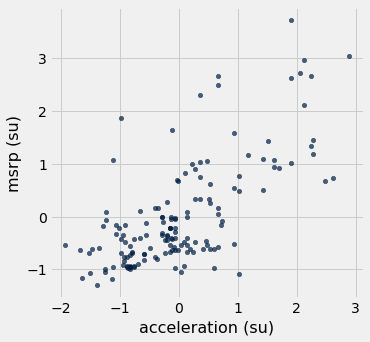

In [75]:
hybrid_su.scatter('acceleration (su)', 'msrp (su)')

In [76]:
#:
(
    hybrid_su
    .select('acceleration (su)', 'msrp (su)')
    .with_column('product of su', hybrid_su.column('acceleration (su)') * hybrid_su.column('msrp (su)'))
)

acceleration (su),msrp (su),product of su
-1.53501,-0.69363,1.06473
-1.2825,-0.18568,0.238135
-1.36098,-0.584852,0.795974
-0.832081,-0.954663,0.794357
-1.67832,-0.631636,1.06009
-0.832081,-0.949966,0.790448
-0.767248,-0.945268,0.725255
-1.23814,-0.057827,0.071598
-0.832081,-0.945268,0.78654
-1.13919,-1.1825,1.34708


In [61]:
#:
r = np.mean(hybrid_su.column('acceleration (su)') * hybrid_su.column('msrp (su)'))
r

0.6955778996913978

## The Correlation Coefficient $r$

* Measures how clustered points are around a straight line (linear association)
* Based on standard units
* $-1 \leq r \leq 1$
    - $r = 1$: scatterplot is a line of slope 1.
    - $r = -1$: scatterplot is a line of slope -1.
* $r = 0$: no linear association; *uncorrelated*.

### Calculate the $r$ for `mpg` and `msrp`

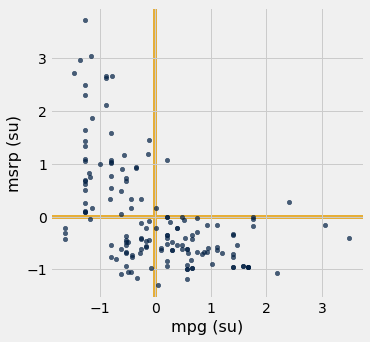

In [69]:
hybrid_su.scatter('mpg (su)', 'msrp (su)')
plt.axhline(color='C2', zorder=0)
plt.axvline(color='C2', zorder=0)

In [70]:
#:
(
    hybrid_su
    .select('mpg (su)', 'msrp (su)')
    .with_column('product of su', hybrid_su.column('mpg (su)') * hybrid_su.column('msrp (su)'))
)

mpg (su),msrp (su),product of su
0.59091,-0.69363,-0.409873
1.76495,-0.18568,-0.327716
0.953911,-0.584852,-0.557897
1.66437,-0.954663,-1.58891
1.11941,-0.631636,-0.707059
1.66437,-0.949966,-1.58109
1.66437,-0.945268,-1.57327
0.517761,-0.057827,-0.0299406
1.66437,-0.945268,-1.57327
0.567137,-1.1825,-0.670638


In [72]:
#:
r = np.mean(hybrid_su.column('mpg (su)') * hybrid_su.column('msrp (su)'))
r

-0.5318263633683786

## Scatterplots with given correlation coefficients

In [77]:
#:
def r_scatter(r):
    plt.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plt.scatter(x, y)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.suptitle('r = %f' %r, fontsize=14)

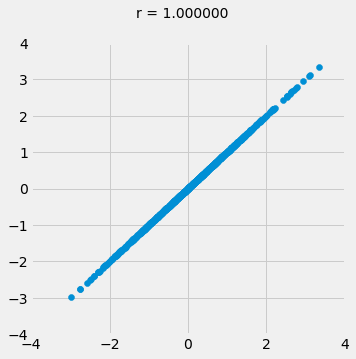

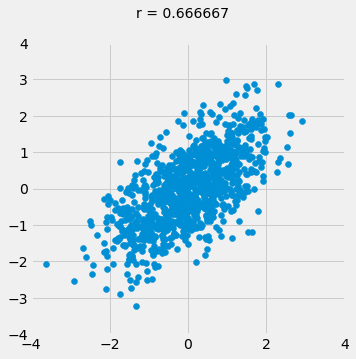

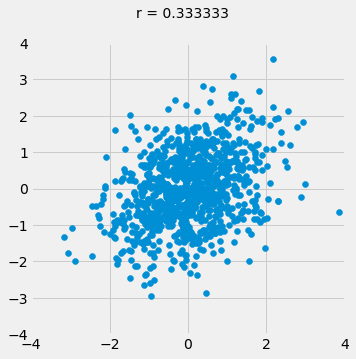

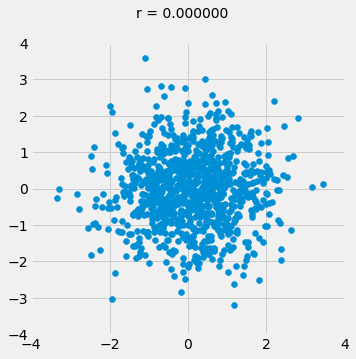

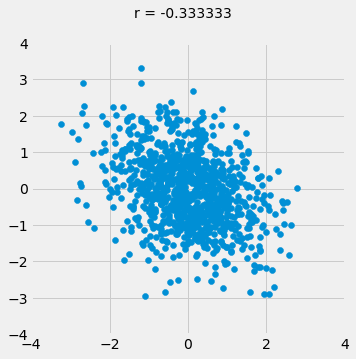

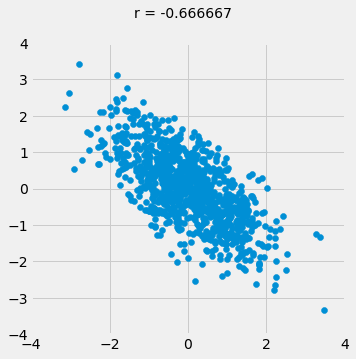

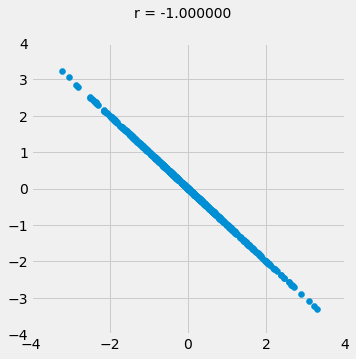

In [78]:
#:
for r in np.linspace(1, -1, 7):
    r_scatter(r)

### Discussion Question
Does the following scatter plot show:

- A. Association and correlation
- B. Association but not correlation
- C. Correlation but not association
- D. Neither association nor correlation

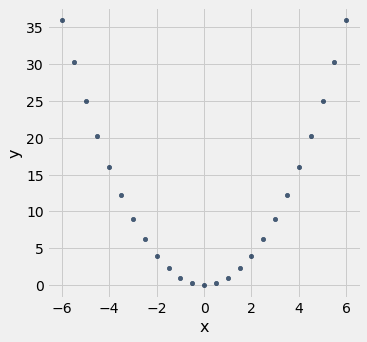

In [79]:
x2 = Table().with_columns(
    'x', np.arange(-6, 6.1, 0.5), 
    'y', np.arange(-6, 6.1, 0.5)**2)
x2.scatter('x', 'y')

### Answer

In [80]:
products = standard_units(x2.column('x')) * standard_units(x2.column('y'))
products

array([-3.2996324 , -2.26849727, -1.43462278, -0.78007614, -0.28692456,
        0.06276475,  0.28692456,  0.40348766,  0.43038683,  0.38555487,
        0.28692456,  0.15242867, -0.        , -0.15242867, -0.28692456,
       -0.38555487, -0.43038683, -0.40348766, -0.28692456, -0.06276475,
        0.28692456,  0.78007614,  1.43462278,  2.26849727,  3.2996324 ])

In [81]:
np.mean(products)

0.0

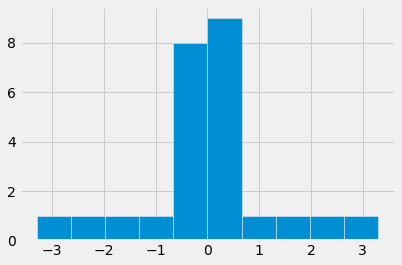

In [82]:
plt.hist(products);

## Child height prediction, revisited
* Calculate the correlation between `midparentHeight` and `childHeight`

In [87]:
heights_su = standardize(heights)
heights_su

MidParent (su),Child (su)
3.45465,1.80416
3.45465,0.686005
3.45465,0.630097
3.45465,0.630097
2.47209,1.88802
2.47209,1.60848
2.47209,-0.348285
2.47209,-0.348285
1.58389,1.18917
1.58389,0.350559


In [88]:
r = np.mean(heights_su.column('MidParent (su)') * heights_su.column('Child (su)'))
r

0.32094989606395924

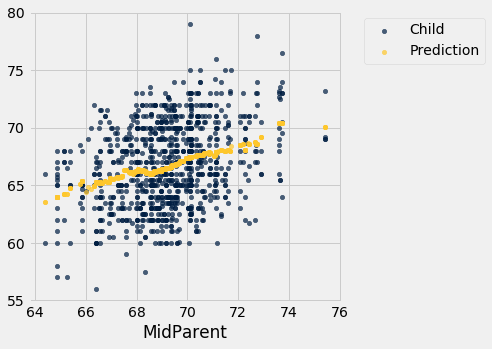

In [89]:
heights_and_predict.scatter(0)

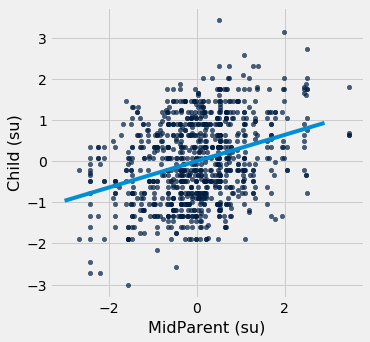

In [92]:
heights_su.scatter(0)
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1) * r);

## Using the correlation coefficient for prediction
In standard units:
* The line through $(0,0)$ with slope $r$ is called the regression line.
* If the association between attributes is linear, the graph of averages is approximately the regression line.
* If the line is given by $f(x) = mx + b$, then the prediction for $x$ is given by $f(x)$.

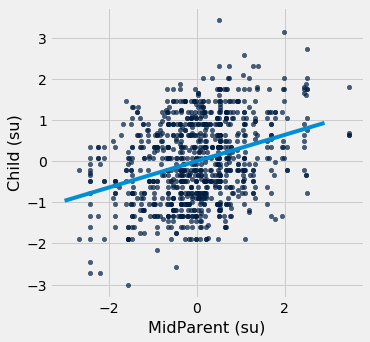

In [157]:
heights_su.scatter(0)
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1) * r);

### Regression to the mean

* The regression line predicts:
    - Parent's whose mid-parent height is ~2 su have children with height ~0.6 su.
    - We predict that the child will be somewhat closer to average than their parents.
* This is a consequence of the slope having magnitude less than 1.

## Regression to the Mean
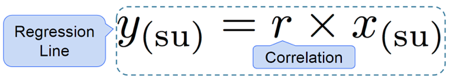

* If $r = 0.6$, and the given $x$ is 2 standard units, then:
    - The given $x$ is 2 SDs above average
    - The prediction for $y$ is 1.2 SDs above average

* On average (though not for each individual), regression predicts $y$ to be closer to the mean than $x$.

### Child height prediction, original units
Approach:
1. Scale mid-parent height to standard units
2. Use the correlation coefficient to predict child height
3. Scale predicted child height from standard units back to inches

In [93]:
#:
parent_mean = np.mean(heights.column('MidParent'))
parent_sd = np.std(heights.column('MidParent'))
child_mean = np.mean(heights.column('Child'))
child_sd = np.std(heights.column('Child'))

In [94]:
#:
def predict_with_r(parent):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of parent, 
    using linear regression.
    """
    parent_su = (parent - parent_mean) / parent_sd
    child_su = r * parent_su
    return child_su * child_sd + child_mean

In [95]:
#:
predict_with_r(56)

58.32845077988057

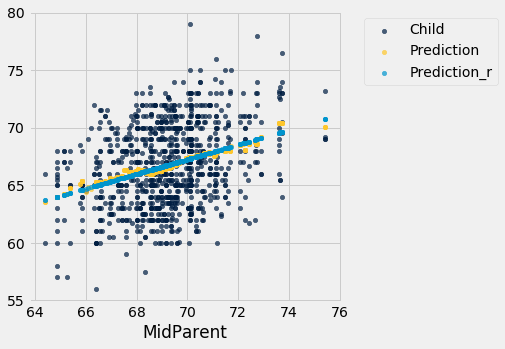

In [96]:
#:
preds = heights_and_predict.with_column('Prediction_r', heights.apply(predict_with_r, 'MidParent'))
preds.scatter(0)

### Discussion Question

A course has a midterm (average 70; standard deviation 10) and a really hard final (average 50; standard deviation 12)

If the scatter diagram comparing midterm & final scores for students looks linearly associated with correlation 0.75, then what is the predicted final exam score for a student who received a 90 on the midterm?

- A.76
- B.90
- C.68
- D.82
- E.67.5

### Answer

1. (90 - 70)/10 = 2 standard units on midterm, 
2. estimate 0.75 * 2 = 1.5 standard units on final 
3. estimated final score = 1.5 * 12 + 50 = 68 points

## Slope and Intercept

* What does the regression line look like in original units?

## Regression line equation

In original units, the regression line has this equation:

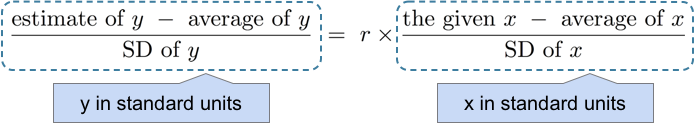


## Regression line equation:

* In standard units:
$$ y = r \times x $$
* In original units, 
    - where $m_x$, $m_y$ are the averages of $x$ and $y$
    - where $s_x$, $s_y$ are the standard deviations of $x$ and $y$,
$$\frac{(y - m_y)}{s_y} = r \times \frac{(x - m_x)}{s_x}$$
* This equation reworked into the point-slope form of a line:
$$(y - m_y) = \left(\frac{r\cdot s_y}{s_x}\right)(x - m_x)$$

* Or in the slope-intercept form:

$$y = \left(\frac{r\cdot s_y}{s_x}\right)x + \left(m_y - \frac{r\cdot s_y\cdot m_x}{s_x}\right)$$

## Slope and intercept

* The regression line is given by $y = mx + b$, where:
    - the slope $m$ is: $$m = r\cdot\frac{SD\ of\ x}{SD\ of\ y}$$
    - the y-intercept $b$ is: $$b = (avg\ of\ y) - m\cdot(avg\ of\ x)$$


## The regression line
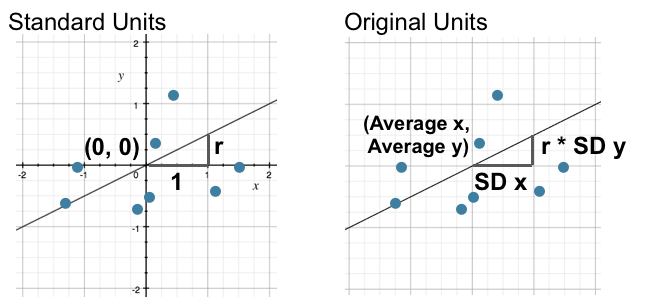

### Predict the retail price of a hybrid with acceleration of 12.5
* For each additional unit of acceleration (kph/s), how does the price change?

In [97]:
#:
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)"""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)"""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))


In [99]:
m = slope(hybrid, 'acceleration', 'msrp')
b = intercept(hybrid, 'acceleration', 'msrp')

y = m * 12.5 + b
y

42063.58975574111

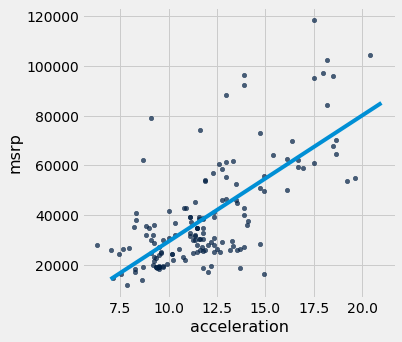

In [100]:
hybrid.scatter('acceleration', 'msrp')
x = np.arange(7,22)
plt.plot(x, m * x + b);

In [102]:
m

5067.6611059552215